In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from anm.gaze_dataloader.dataset import _create_senteces_from_data
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
sns.set_style('darkgrid')

In [2]:
method = 'alti'
positive_corr = True
eye_tracking_feature = 'skip'

In [3]:
plots_out_dir = f'../output/attn_corr_plots/{method}/{eye_tracking_feature}'

In [4]:
def get_src_paths(language, method, language_mode):
    meco_data_dir = '../augmenting_nlms_meco_data/'
    eye_tracking_dir = os.path.join(meco_data_dir, language)
    attention_extraction_output_dir = '../output/attn_data/'
    attention_dir = os.path.join(attention_extraction_output_dir, method, language, language_mode)
    return eye_tracking_dir, attention_dir

In [5]:
def load_eye_tracking_data(src_path, col):
    data = pd.read_csv(src_path, index_col=0)
    gaze_dataset = _create_senteces_from_data(data, [col], keep_id=True)
    return gaze_dataset

In [6]:
def load_model_attention(src_path):
    with open(src_path, 'r') as src_file:
        model_attention = json.load(src_file)
    return model_attention

In [7]:
def normalize_list(l):
    return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()

In [8]:
def compute_correlation(eye_tracking_dataset, model_attention_dict):
    all_human_attentions = []
    all_model_attentions = []
    feature_name = [col_name for col_name in eye_tracking_dataset.column_names if col_name not in ['id', 'text']][0]
    
    for sent_id, human_attention in zip(eye_tracking_dataset['id'], eye_tracking_dataset[feature_name]):
        model_attention = model_attention_dict[sent_id]
        all_human_attentions += normalize_list(human_attention)
        all_model_attentions += normalize_list(model_attention)
        # if np.max(human_attention)-np.min(human_attention) == 0:
        #     print('human')
        #     print(human_attention)
        # if np.max(model_attention)-np.min(model_attention) == 0:
        #     print('model')

    s = spearmanr(all_model_attentions, all_human_attentions)
    if s.pvalue < 0.05:
        if positive_corr:
            return max(s.statistic, -s.statistic)
        else:
            return s.statistic
    else:
        return 0.0

In [9]:
def compute_correlations_df(attention_dir, eye_tracking_dir):
    
    training_configs = os.listdir(attention_dir)
    correlations_dict = {'training_config':[], 'layer':[], 'correlation':[], 'user':[]}
    for training_config in training_configs:
        
        config_attention_dir = os.path.join(attention_dir, training_config)
        
        for user_id in os.listdir(config_attention_dir):
            eye_tracking_path = os.path.join(eye_tracking_dir, f'{language}_{user_id}_dataset.csv')
            eye_tracking_data = load_eye_tracking_data(eye_tracking_path, eye_tracking_feature)
            
            user_attention_dir = os.path.join(config_attention_dir, user_id)
            for layer in range(12):
                layer_attention_path = os.path.join(user_attention_dir, f'{layer}.json')
                layer_attention = load_model_attention(layer_attention_path)
                # print('training conf', training_config)
                corr = compute_correlation(eye_tracking_data, layer_attention)
                correlations_dict['training_config'].append(training_config)
                correlations_dict['layer'].append(layer)
                correlations_dict['correlation'].append(corr)
                correlations_dict['user'].append(user_id)
    return pd.DataFrame.from_dict(correlations_dict)

In [10]:
def plot_users(correlations_df, out_dir):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    for i, user_id in enumerate(sorted(correlations_df['user'].unique())):
        legend = True if i == 0 else False
        plt.ylim(-0.05, 0.9)
        user_df = correlations_df[correlations_df['user'] == user_id]
        sns.lineplot(data=user_df, x='layer', y='correlation', hue='training_config', legend=legend).set(title=f'User {user_id}');
        plt.savefig(os.path.join(out_dir, f'{user_id}.png'))
        plt.show()
        plt.clf()

# Attention Matrix
## Monolingual EN

In [11]:
language = 'en'
language_mode = 'mono_lingual'
out_dir = os.path.join(plots_out_dir, language_mode, language)

In [12]:
eye_tracking_dir, attention_dir = get_src_paths(language, method, language_mode)
correlations_df = compute_correlations_df(attention_dir, eye_tracking_dir)

/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.m

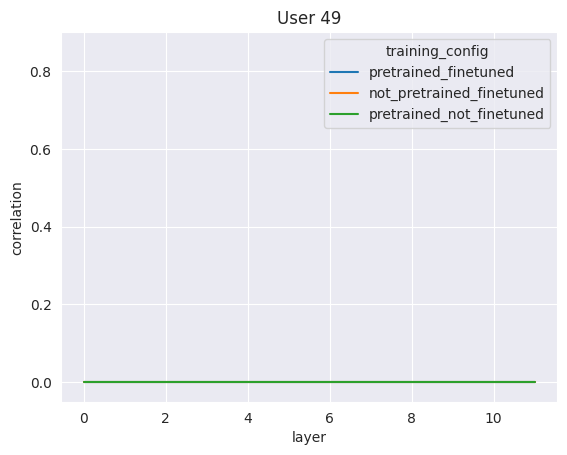

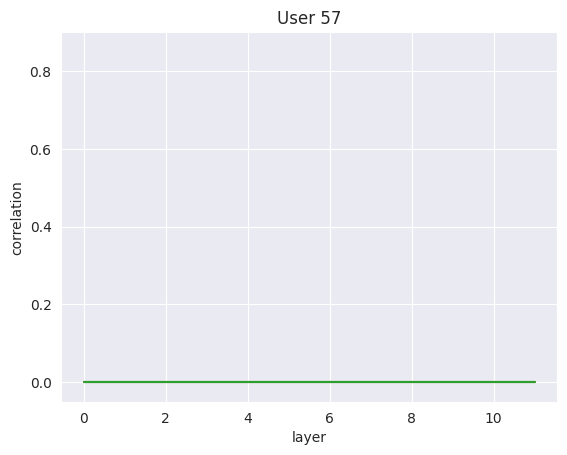

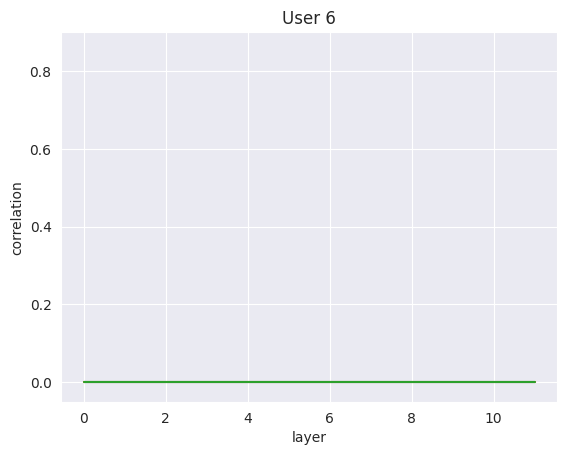

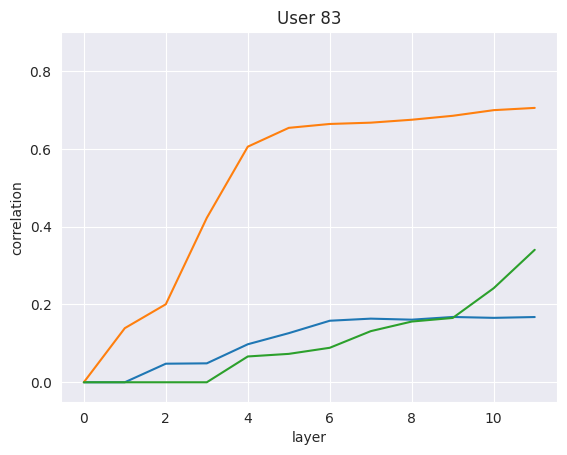

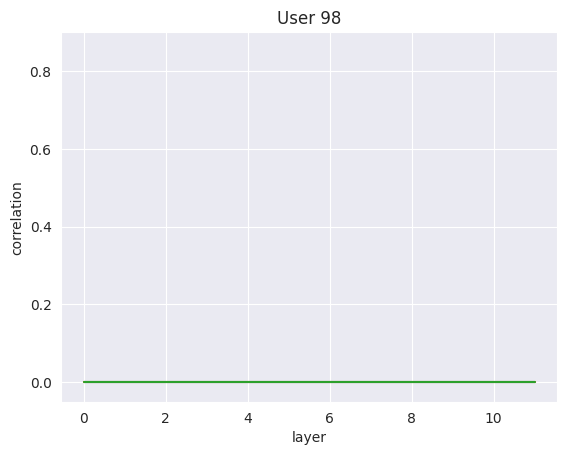

<Figure size 640x480 with 0 Axes>

In [13]:
plot_users(correlations_df, out_dir)

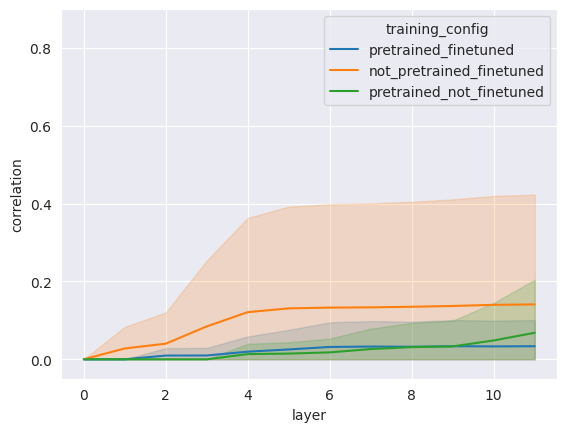

In [14]:
sns.lineplot(data=correlations_df, x='layer', y='correlation', hue='training_config');
plt.ylim(-0.05, 0.9)
plt.savefig(os.path.join(out_dir, f'users_mean.png'))

## Cross-lingual EN

In [15]:
language = 'en'
language_mode = 'cross_lingual'
out_dir = os.path.join(plots_out_dir, language_mode, language)

In [16]:
eye_tracking_dir, attention_dir = get_src_paths(language, method, language_mode)
correlations_df = compute_correlations_df(attention_dir, eye_tracking_dir)

/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.m

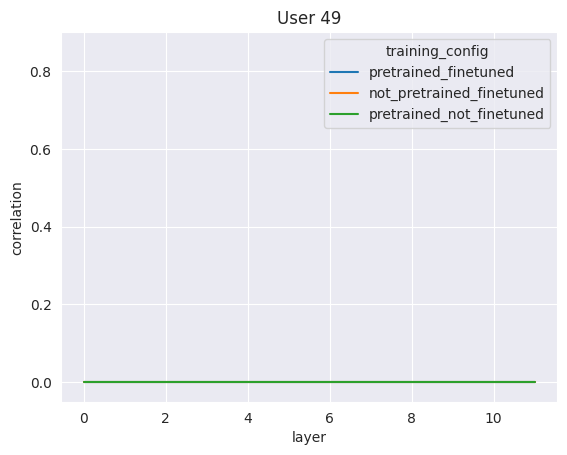

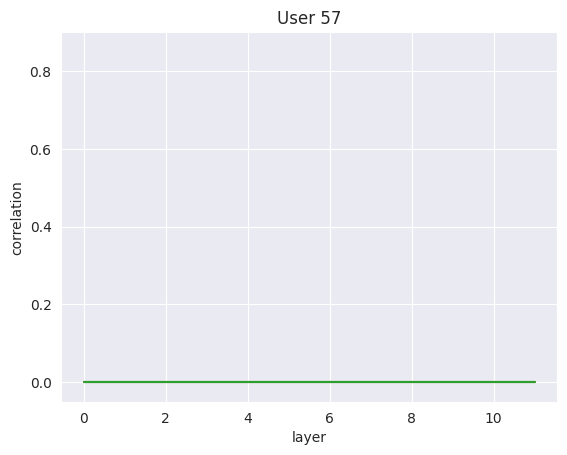

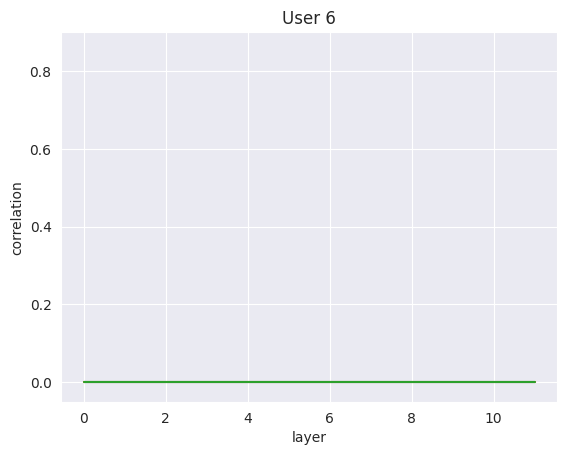

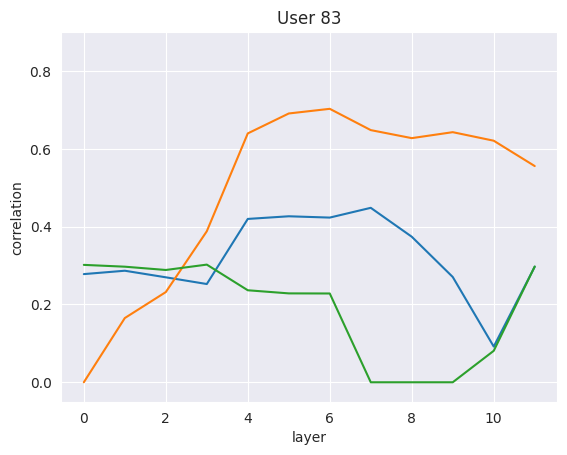

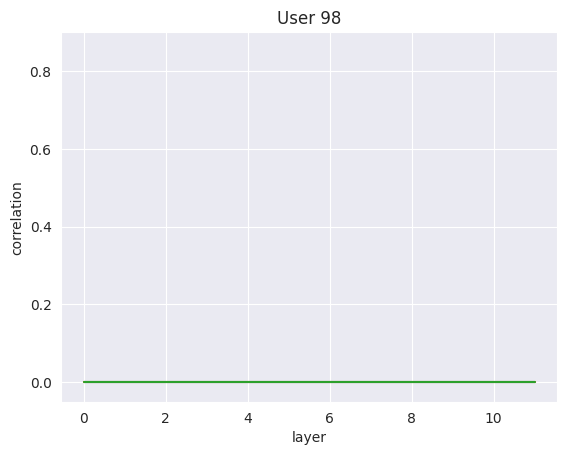

<Figure size 640x480 with 0 Axes>

In [17]:
plot_users(correlations_df, out_dir)

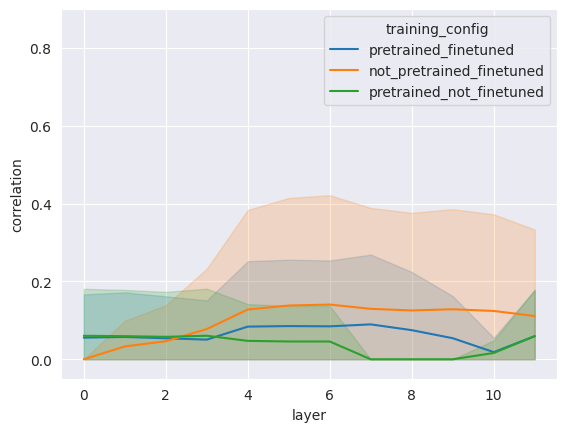

In [18]:
plt.ylim(-0.05, 0.9)
sns.lineplot(data=correlations_df, x='layer', y='correlation', hue='training_config');
plt.savefig(os.path.join(out_dir, f'users_mean.png'))

## Monolingual IT

In [19]:
language = 'it'
language_mode = 'mono_lingual'
out_dir = os.path.join(plots_out_dir, language_mode, language)

In [20]:
eye_tracking_dir, attention_dir = get_src_paths(language, method, language_mode)
correlations_df = compute_correlations_df(attention_dir, eye_tracking_dir)

/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.

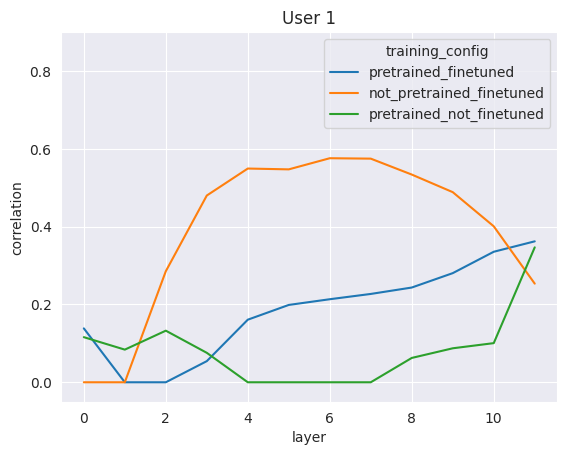

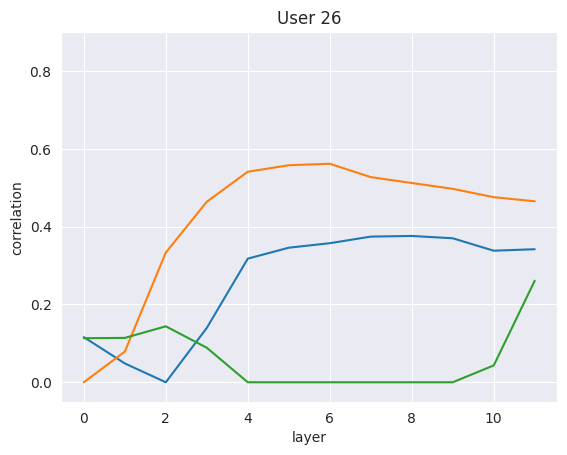

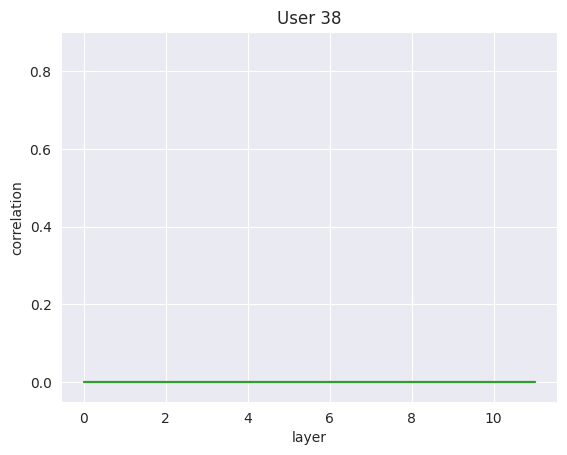

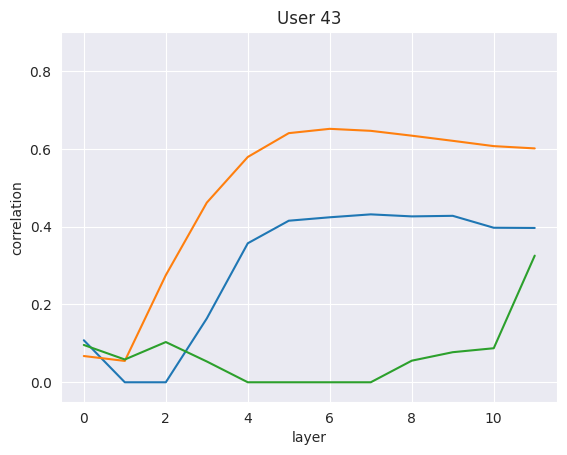

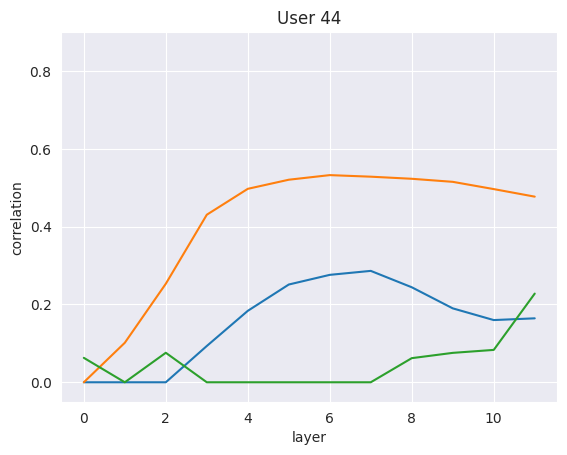

<Figure size 640x480 with 0 Axes>

In [21]:
plot_users(correlations_df, out_dir)

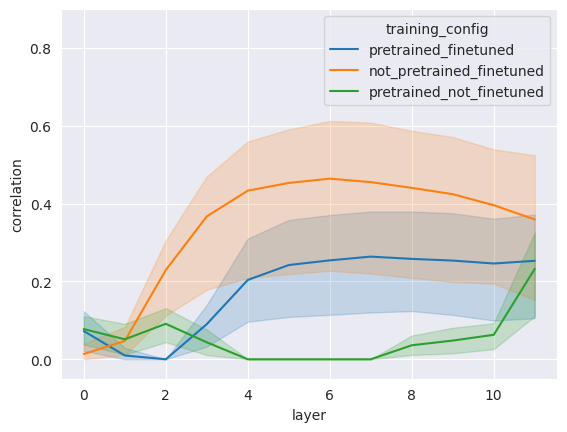

In [22]:
plt.ylim(-0.05, 0.9)
sns.lineplot(data=correlations_df, x='layer', y='correlation', hue='training_config');
plt.savefig(os.path.join(out_dir, f'users_mean.png'))

## Cross-lingual IT

In [23]:
language = 'it'
language_mode = 'cross_lingual'
out_dir = os.path.join(plots_out_dir, language_mode, language)

In [24]:
eye_tracking_dir, attention_dir = get_src_paths(language, method, language_mode)
correlations_df = compute_correlations_df(attention_dir, eye_tracking_dir)

/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()
/tmp/ipykernel_1631509/1618583829.py:2: RuntimeWarning: invalid value encountered in divide
  return ((l-np.m

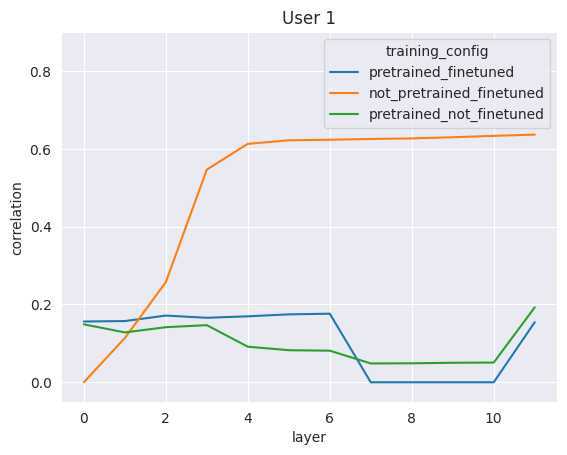

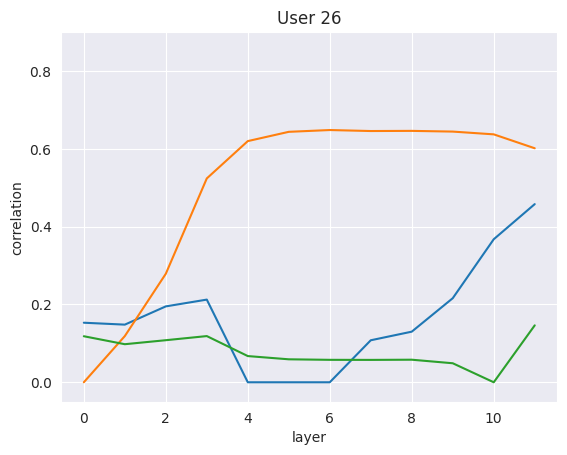

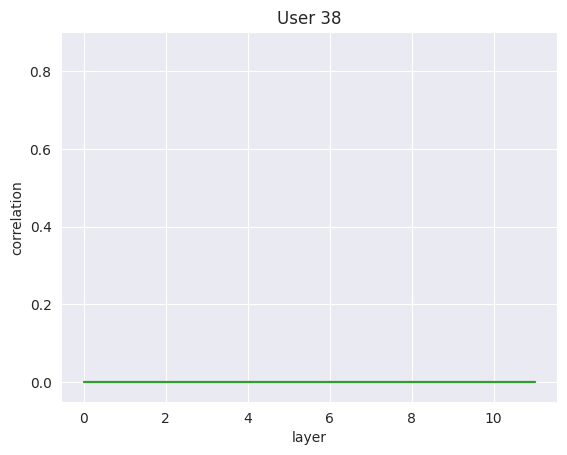

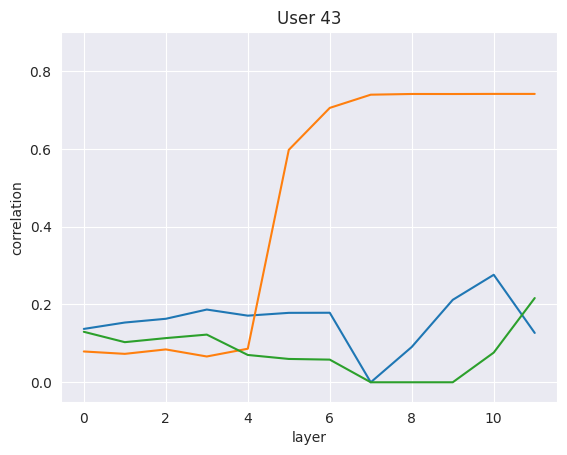

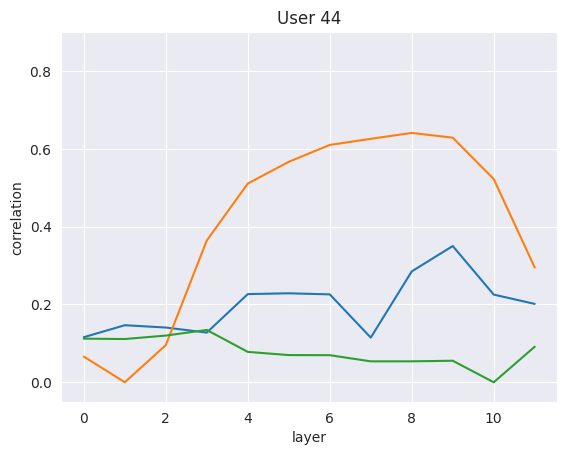

<Figure size 640x480 with 0 Axes>

In [25]:
plot_users(correlations_df, out_dir)

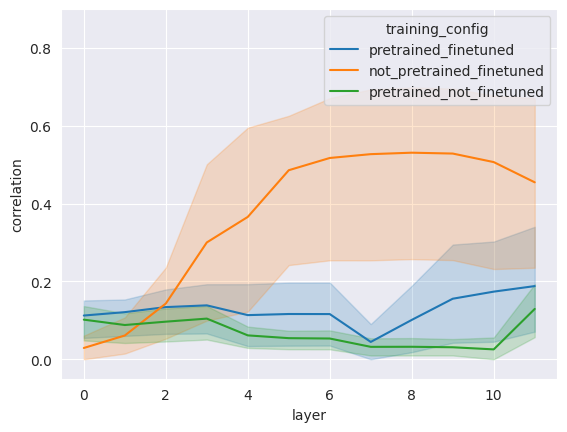

In [26]:
plt.ylim(-0.05, 0.9)
sns.lineplot(data=correlations_df, x='layer', y='correlation', hue='training_config');
plt.savefig(os.path.join(out_dir, f'users_mean.png'))